# Model Training
Finally we get to the good stuff. We will use polynomial regression which will probably suck due to too many oscillations in the train dataset, randomforest which might actually work decently well, and lgbm which I am not too familiar with, and will probably fail utilising well. I'm pretty sure lags/rolls should have been implemented differently but I guess you live and learn. Noone said this project has to win the competition that has been closed for like 2 years anyway.

### WRMSSE Calculation
As mentioned in notebook 1, these metrics will be used to determine our models score.
Big thanks to sakami for this implementation:
https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

Note that due to having a competition leaderboard, we will forgo making a baseline model in lieu of a simple score comparison.

I will also refrain from reformatting the results into the proper submission format as there is nothing to submit anyway. The WRMSSE scores should be good enough to judge the models, I might go back to this and add it later, but for now this will have to do.

In [3]:
from typing import Union

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm


class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

## Imports and reading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from downcast import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from lightgbm import LGBMRegressor, LGBMClassifier, Booster

In [2]:
train = pd.read_pickle('df_train_final.pkl').reset_index().set_index('date')
test = pd.read_pickle('df_test_final.pkl').reset_index().set_index('date')

train = train.reset_index().set_index('date')
test = test.reset_index().set_index('date')

train = reduce(train)
test = reduce(test)

## Feature selection and final splits

In [3]:
train.columns

Index(['index', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'wm_yr_wk', 'wday', 'month', 'year', 'items_sold', 'sell_price',
       'event_num', 'snap', 'weekend', 'season', 'item_id_label',
       'dept_id_label', 'cat_id_label', 'store_id_label', 'state_id_label',
       'lag_7', 'lag_28', 'lag_35', 'lag_42', 'lag_60', 'lag_360', 'rmean_7_7',
       'rmean_28_7', 'rmean_35_7', 'rmean_42_7', 'rmean_60_7', 'rmean_360_7',
       'rmean_7_28', 'rmean_28_28', 'rmean_35_28', 'rmean_42_28',
       'rmean_60_28', 'rmean_360_28', 'rmean_7_35', 'rmean_28_35',
       'rmean_35_35', 'rmean_42_35', 'rmean_60_35', 'rmean_360_35',
       'rmean_7_42', 'rmean_28_42', 'rmean_35_42', 'rmean_42_42',
       'rmean_60_42', 'rmean_360_42', 'rmean_7_60', 'rmean_28_60',
       'rmean_35_60', 'rmean_42_60', 'rmean_60_60', 'rmean_360_60',
       'rmean_7_360', 'rmean_28_360', 'rmean_35_360', 'rmean_42_360',
       'rmean_60_360', 'rmean_360_360'],
      dtype='object')

In [4]:
unused = ['index', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','wm_yr_wk','items_sold',]
features = list(set(train.columns)-set(unused))
target = ['items_sold']

In [5]:
features

['weekend',
 'lag_60',
 'rmean_360_28',
 'rmean_28_7',
 'rmean_42_28',
 'rmean_35_28',
 'item_id_label',
 'rmean_35_42',
 'dept_id_label',
 'rmean_7_28',
 'lag_28',
 'rmean_42_60',
 'rmean_7_42',
 'rmean_360_60',
 'rmean_42_35',
 'rmean_60_360',
 'rmean_360_360',
 'wday',
 'lag_42',
 'lag_7',
 'rmean_35_35',
 'rmean_360_42',
 'rmean_60_60',
 'snap',
 'sell_price',
 'month',
 'rmean_360_35',
 'rmean_60_35',
 'rmean_360_7',
 'rmean_28_60',
 'rmean_35_7',
 'rmean_28_35',
 'store_id_label',
 'rmean_7_60',
 'year',
 'rmean_60_7',
 'rmean_60_28',
 'rmean_42_360',
 'rmean_7_35',
 'rmean_28_28',
 'lag_35',
 'rmean_60_42',
 'rmean_35_60',
 'rmean_7_360',
 'rmean_28_360',
 'cat_id_label',
 'rmean_35_360',
 'season',
 'rmean_42_42',
 'rmean_7_7',
 'rmean_42_7',
 'rmean_28_42',
 'lag_360',
 'state_id_label',
 'event_num']

In [6]:
X_train = train[features].fillna(0)
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [7]:
# We have data from 2014-2016 so 3 splits seems pretty good
tss = TimeSeriesSplit(n_splits=3)

## 1. Linear Regression
For the purpose of polynomial regression we will remove all the lags/rolling features because my pc blows up. Those are really only there for LGBM anyway.

In [30]:
X_train_nolags = X_train[['weekend','cat_id_label','event_num','season','sell_price',
                       'snap','month','wday','year','store_id_label','state_id_label']]
X_test_nolags = X_test[['weekend','cat_id_label','event_num','season','sell_price',
                       'snap','month','wday','year','store_id_label','state_id_label']]

In [54]:
linear_reg = make_pipeline(StandardScaler(), LinearRegression())
params = {}
linear_reg_gridsearch = GridSearchCV(
    linear_reg, 
    params,
    scoring='neg_mean_squared_error',
    cv=tss,
    n_jobs = None,
    verbose=10)

linear_reg_gridsearch.fit(X_train_nolags, y_train)
linear_regfinal = linear_reg_gridsearch.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START ............................................................
[CV 1/3; 1/1] END ............................, score=-11.401 total time=   2.3s
[CV 2/3; 1/1] START ............................................................
[CV 2/3; 1/1] END ............................, score=-13.182 total time=   3.9s
[CV 3/3; 1/1] START ............................................................
[CV 3/3; 1/1] END ............................, score=-12.090 total time=   5.6s


In [55]:
linear_regfinal.fit(X_train_nolags, y_train)
y_train_pred_lr = linear_regfinal.predict(X_train_nolags)
y_test_pred_lr = linear_regfinal.predict(X_test_nolags)

rmse_train =sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test =sqrt(mean_squared_error(y_test, y_test_pred))

In [56]:
print(f'rmse_train: {rmse_train}, rmse_test: {rmse_test}')

rmse_train: 3.5637158109429197, rmse_test: 3.5780065258685196


# 2. Random Forest
We will use the same nolags model for our trees.

In [12]:
random_forest = RandomForestRegressor(n_jobs=-1,max_features=0.33)

params_rf = {'max_depth': [2, 3, 5, 10, 20],
             'min_samples_leaf': [7, 14, 28, 56],
             'n_estimators': [7,14,28]} #the number of decision trees you will be running in the model/the number of trees in the forest.

rf_gridsearch = GridSearchCV(random_forest,
                             params_rf, 
                             scoring='neg_mean_absolute_error',
                             cv=tss,
                             verbose=10, 
                             n_jobs=None)
rf_gridsearch.fit(X_train_nolags, y_train.values.ravel())
random_forest = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3; 1/60] START max_depth=2, min_samples_leaf=7, n_estimators=7............
[CV 1/3; 1/60] END max_depth=2, min_samples_leaf=7, n_estimators=7;, score=-1.502 total time=   3.2s
[CV 2/3; 1/60] START max_depth=2, min_samples_leaf=7, n_estimators=7............
[CV 2/3; 1/60] END max_depth=2, min_samples_leaf=7, n_estimators=7;, score=-1.530 total time=   5.5s
[CV 3/3; 1/60] START max_depth=2, min_samples_leaf=7, n_estimators=7............
[CV 3/3; 1/60] END max_depth=2, min_samples_leaf=7, n_estimators=7;, score=-1.534 total time=   7.9s
[CV 1/3; 2/60] START max_depth=2, min_samples_leaf=7, n_estimators=14...........
[CV 1/3; 2/60] END max_depth=2, min_samples_leaf=7, n_estimators=14;, score=-1.489 total time=   5.0s
[CV 2/3; 2/60] START max_depth=2, min_samples_leaf=7, n_estimators=14...........
[CV 2/3; 2/60] END max_depth=2, min_samples_leaf=7, n_estimators=14;, score=-1.514 total time=   9.9s
[CV 3/3; 2/60] START max_d

[CV 3/3; 15/60] END max_depth=3, min_samples_leaf=7, n_estimators=28;, score=-1.525 total time=  34.6s
[CV 1/3; 16/60] START max_depth=3, min_samples_leaf=14, n_estimators=7..........
[CV 1/3; 16/60] END max_depth=3, min_samples_leaf=14, n_estimators=7;, score=-1.473 total time=   3.9s
[CV 2/3; 16/60] START max_depth=3, min_samples_leaf=14, n_estimators=7..........
[CV 2/3; 16/60] END max_depth=3, min_samples_leaf=14, n_estimators=7;, score=-1.517 total time=   6.8s
[CV 3/3; 16/60] START max_depth=3, min_samples_leaf=14, n_estimators=7..........
[CV 3/3; 16/60] END max_depth=3, min_samples_leaf=14, n_estimators=7;, score=-1.530 total time=  11.8s
[CV 1/3; 17/60] START max_depth=3, min_samples_leaf=14, n_estimators=14.........
[CV 1/3; 17/60] END max_depth=3, min_samples_leaf=14, n_estimators=14;, score=-1.472 total time=   6.9s
[CV 2/3; 17/60] START max_depth=3, min_samples_leaf=14, n_estimators=14.........
[CV 2/3; 17/60] END max_depth=3, min_samples_leaf=14, n_estimators=14;, score=-

[CV 3/3; 30/60] END max_depth=5, min_samples_leaf=14, n_estimators=28;, score=-1.504 total time= 1.0min
[CV 1/3; 31/60] START max_depth=5, min_samples_leaf=28, n_estimators=7..........
[CV 1/3; 31/60] END max_depth=5, min_samples_leaf=28, n_estimators=7;, score=-1.465 total time=   5.4s
[CV 2/3; 31/60] START max_depth=5, min_samples_leaf=28, n_estimators=7..........
[CV 2/3; 31/60] END max_depth=5, min_samples_leaf=28, n_estimators=7;, score=-1.493 total time=  10.0s
[CV 3/3; 31/60] START max_depth=5, min_samples_leaf=28, n_estimators=7..........
[CV 3/3; 31/60] END max_depth=5, min_samples_leaf=28, n_estimators=7;, score=-1.500 total time=  13.9s
[CV 1/3; 32/60] START max_depth=5, min_samples_leaf=28, n_estimators=14.........
[CV 1/3; 32/60] END max_depth=5, min_samples_leaf=28, n_estimators=14;, score=-1.457 total time=   9.1s
[CV 2/3; 32/60] START max_depth=5, min_samples_leaf=28, n_estimators=14.........
[CV 2/3; 32/60] END max_depth=5, min_samples_leaf=28, n_estimators=14;, score=

[CV 3/3; 45/60] END max_depth=10, min_samples_leaf=28, n_estimators=28;, score=-1.467 total time= 1.7min
[CV 1/3; 46/60] START max_depth=10, min_samples_leaf=56, n_estimators=7.........
[CV 1/3; 46/60] END max_depth=10, min_samples_leaf=56, n_estimators=7;, score=-1.431 total time=   7.0s
[CV 2/3; 46/60] START max_depth=10, min_samples_leaf=56, n_estimators=7.........
[CV 2/3; 46/60] END max_depth=10, min_samples_leaf=56, n_estimators=7;, score=-1.458 total time=  16.0s
[CV 3/3; 46/60] START max_depth=10, min_samples_leaf=56, n_estimators=7.........
[CV 3/3; 46/60] END max_depth=10, min_samples_leaf=56, n_estimators=7;, score=-1.469 total time=  32.1s
[CV 1/3; 47/60] START max_depth=10, min_samples_leaf=56, n_estimators=14........
[CV 1/3; 47/60] END max_depth=10, min_samples_leaf=56, n_estimators=14;, score=-1.425 total time=  14.7s
[CV 2/3; 47/60] START max_depth=10, min_samples_leaf=56, n_estimators=14........
[CV 2/3; 47/60] END max_depth=10, min_samples_leaf=56, n_estimators=14;, 

[CV 3/3; 60/60] END max_depth=20, min_samples_leaf=56, n_estimators=28;, score=-1.437 total time= 2.5min


In [47]:
y_train_pred_rf = random_forest.predict(X_train_nolags)
y_test_pred_rf = random_forest.predict(X_test_nolags)

rmse_train =sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_test =sqrt(mean_squared_error(y_test, y_test_pred_rf))

In [48]:
print(f'rmse_train: {rmse_train}, rmse_test: {rmse_test}')

rmse_train: 3.1610962650355, rmse_test: 3.248270722756284


## 3.  LGBM Regression

In [8]:
#some params for tuning

param_dist = {
    'boosting_type': ['gbdt'],
    'objective': ['tweedie'],
    'tweedie_variance_power': [1.1],
    'n_estimators': [500],
    'metric': ['rmse'],
    'max_depth': [30, 50, 70],
    'num_leaves': [250, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'feature_fraction': [0.5, 0.7],
    'bagging_fraction': [0.5, 0.7],
}

reg = lgb.LGBMRegressor()

In [9]:
random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=1,
    cv=tss,
    scoring='neg_mean_squared_error',
    n_jobs=None,
)

In [10]:
random_search.fit(
    X_train,
    y_train,
    eval_metric='rmse',
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's rmse: 3.58253	valid_1's rmse: 3.61695
[2]	valid_0's rmse: 3.55195	valid_1's rmse: 3.58366
[3]	valid_0's rmse: 3.51944	valid_1's rmse: 3.54871
[4]	valid_0's rmse: 3.48567	valid_1's rmse: 3.51196
[5]	valid_0's rmse: 3.44996	valid_1's rmse: 3.4738
[6]	valid_0's rmse: 3.41305	valid_1's rmse: 3.43411
[7]	valid_0's rmse: 3.37555	valid_1's rmse: 3.39361
[8]	valid_0's rmse: 3.33785	valid_1's rmse: 3.35262
[9]	valid_0's rmse: 3.2992	valid_1's rmse: 3.31084
[10]	valid_0's rmse: 3.26038	valid_1's rmse: 3.26844
[11]	valid_0's rmse: 3.22135	valid_1's rmse: 3.22659
[12]	valid_0's rmse: 3.18262	valid_1's rmse: 3.18492
[13]	valid_0's rmse: 3.14387	valid_1's rmse: 3.14298
[14]	valid_0's rmse: 3.10607	valid_1's rmse: 3.10218
[15]	valid_0's rmse: 3.06873

[151]	valid_0's rmse: 2.13011	valid_1's rmse: 2.05269
[152]	valid_0's rmse: 2.12984	valid_1's rmse: 2.0527
[153]	valid_0's rmse: 2.12962	valid_1's rmse: 2.05261
[154]	valid_0's rmse: 2.12931	valid_1's rmse: 2.05266
[155]	valid_0's rmse: 2.12893	valid_1's rmse: 2.05284
[156]	valid_0's rmse: 2.12861	valid_1's rmse: 2.05311
[157]	valid_0's rmse: 2.12841	valid_1's rmse: 2.053
[158]	valid_0's rmse: 2.12816	valid_1's rmse: 2.05311
[159]	valid_0's rmse: 2.12799	valid_1's rmse: 2.05313
[160]	valid_0's rmse: 2.12789	valid_1's rmse: 2.05339
[161]	valid_0's rmse: 2.12743	valid_1's rmse: 2.05334
[162]	valid_0's rmse: 2.12708	valid_1's rmse: 2.05307
[163]	valid_0's rmse: 2.12679	valid_1's rmse: 2.05364
[164]	valid_0's rmse: 2.12651	valid_1's rmse: 2.0537
[165]	valid_0's rmse: 2.12631	valid_1's rmse: 2.0539
[166]	valid_0's rmse: 2.12611	valid_1's rmse: 2.05408
[167]	valid_0's rmse: 2.12616	valid_1's rmse: 2.05462
[168]	valid_0's rmse: 2.12583	valid_1's rmse: 2.05459
[169]	valid_0's rmse: 2.12568	val

[304]	valid_0's rmse: 2.10972	valid_1's rmse: 2.07
[305]	valid_0's rmse: 2.10967	valid_1's rmse: 2.07009
[306]	valid_0's rmse: 2.10974	valid_1's rmse: 2.07007
[307]	valid_0's rmse: 2.10952	valid_1's rmse: 2.07011
[308]	valid_0's rmse: 2.10945	valid_1's rmse: 2.07005
[309]	valid_0's rmse: 2.10942	valid_1's rmse: 2.0701
[310]	valid_0's rmse: 2.1094	valid_1's rmse: 2.07009
[311]	valid_0's rmse: 2.10938	valid_1's rmse: 2.07014
[312]	valid_0's rmse: 2.10934	valid_1's rmse: 2.07038
[313]	valid_0's rmse: 2.10925	valid_1's rmse: 2.07042
[314]	valid_0's rmse: 2.10926	valid_1's rmse: 2.07072
[315]	valid_0's rmse: 2.10918	valid_1's rmse: 2.07072
[316]	valid_0's rmse: 2.10912	valid_1's rmse: 2.07077
[317]	valid_0's rmse: 2.10895	valid_1's rmse: 2.07083
[318]	valid_0's rmse: 2.10898	valid_1's rmse: 2.07126
[319]	valid_0's rmse: 2.10898	valid_1's rmse: 2.07134
[320]	valid_0's rmse: 2.10895	valid_1's rmse: 2.07134
[321]	valid_0's rmse: 2.10895	valid_1's rmse: 2.07145
[322]	valid_0's rmse: 2.10888	val

[457]	valid_0's rmse: 2.10162	valid_1's rmse: 2.08264
[458]	valid_0's rmse: 2.10161	valid_1's rmse: 2.08264
[459]	valid_0's rmse: 2.10146	valid_1's rmse: 2.08263
[460]	valid_0's rmse: 2.10143	valid_1's rmse: 2.08267
[461]	valid_0's rmse: 2.10137	valid_1's rmse: 2.08298
[462]	valid_0's rmse: 2.10127	valid_1's rmse: 2.08301
[463]	valid_0's rmse: 2.10126	valid_1's rmse: 2.08299
[464]	valid_0's rmse: 2.10128	valid_1's rmse: 2.08299
[465]	valid_0's rmse: 2.10118	valid_1's rmse: 2.08309
[466]	valid_0's rmse: 2.10118	valid_1's rmse: 2.08313
[467]	valid_0's rmse: 2.10115	valid_1's rmse: 2.0831
[468]	valid_0's rmse: 2.1011	valid_1's rmse: 2.0831
[469]	valid_0's rmse: 2.10119	valid_1's rmse: 2.08311
[470]	valid_0's rmse: 2.10126	valid_1's rmse: 2.08329
[471]	valid_0's rmse: 2.10127	valid_1's rmse: 2.08334
[472]	valid_0's rmse: 2.10114	valid_1's rmse: 2.08363
[473]	valid_0's rmse: 2.10114	valid_1's rmse: 2.08363
[474]	valid_0's rmse: 2.10116	valid_1's rmse: 2.08408
[475]	valid_0's rmse: 2.10114	v

[107]	valid_0's rmse: 2.11221	valid_1's rmse: 2.07244
[108]	valid_0's rmse: 2.11103	valid_1's rmse: 2.07165
[109]	valid_0's rmse: 2.11003	valid_1's rmse: 2.07102
[110]	valid_0's rmse: 2.10925	valid_1's rmse: 2.07048
[111]	valid_0's rmse: 2.10838	valid_1's rmse: 2.07002
[112]	valid_0's rmse: 2.10746	valid_1's rmse: 2.06964
[113]	valid_0's rmse: 2.10649	valid_1's rmse: 2.06878
[114]	valid_0's rmse: 2.10557	valid_1's rmse: 2.0682
[115]	valid_0's rmse: 2.10503	valid_1's rmse: 2.06776
[116]	valid_0's rmse: 2.10444	valid_1's rmse: 2.06725
[117]	valid_0's rmse: 2.10388	valid_1's rmse: 2.06682
[118]	valid_0's rmse: 2.10329	valid_1's rmse: 2.06642
[119]	valid_0's rmse: 2.10288	valid_1's rmse: 2.06617
[120]	valid_0's rmse: 2.10249	valid_1's rmse: 2.06588
[121]	valid_0's rmse: 2.1018	valid_1's rmse: 2.06555
[122]	valid_0's rmse: 2.1013	valid_1's rmse: 2.06541
[123]	valid_0's rmse: 2.10081	valid_1's rmse: 2.06504
[124]	valid_0's rmse: 2.10012	valid_1's rmse: 2.06522
[125]	valid_0's rmse: 2.09946	v

[260]	valid_0's rmse: 2.04889	valid_1's rmse: 2.06722
[261]	valid_0's rmse: 2.0487	valid_1's rmse: 2.06737
[262]	valid_0's rmse: 2.04857	valid_1's rmse: 2.06714
[263]	valid_0's rmse: 2.04829	valid_1's rmse: 2.06708
[264]	valid_0's rmse: 2.04825	valid_1's rmse: 2.06713
[265]	valid_0's rmse: 2.04793	valid_1's rmse: 2.06709
[266]	valid_0's rmse: 2.04761	valid_1's rmse: 2.06692
[267]	valid_0's rmse: 2.0474	valid_1's rmse: 2.06688
[268]	valid_0's rmse: 2.04728	valid_1's rmse: 2.06694
[269]	valid_0's rmse: 2.04688	valid_1's rmse: 2.06689
[270]	valid_0's rmse: 2.04659	valid_1's rmse: 2.06694
[271]	valid_0's rmse: 2.0463	valid_1's rmse: 2.06685
[272]	valid_0's rmse: 2.04619	valid_1's rmse: 2.06684
[273]	valid_0's rmse: 2.04605	valid_1's rmse: 2.06742
[274]	valid_0's rmse: 2.04585	valid_1's rmse: 2.06744
[275]	valid_0's rmse: 2.04578	valid_1's rmse: 2.06798
[276]	valid_0's rmse: 2.04564	valid_1's rmse: 2.06796
[277]	valid_0's rmse: 2.04543	valid_1's rmse: 2.06806
[278]	valid_0's rmse: 2.04516	v

[413]	valid_0's rmse: 2.02452	valid_1's rmse: 2.08308
[414]	valid_0's rmse: 2.02425	valid_1's rmse: 2.08309
[415]	valid_0's rmse: 2.02401	valid_1's rmse: 2.08307
[416]	valid_0's rmse: 2.02386	valid_1's rmse: 2.08296
[417]	valid_0's rmse: 2.02385	valid_1's rmse: 2.08298
[418]	valid_0's rmse: 2.02382	valid_1's rmse: 2.08298
[419]	valid_0's rmse: 2.02375	valid_1's rmse: 2.08313
[420]	valid_0's rmse: 2.02363	valid_1's rmse: 2.0832
[421]	valid_0's rmse: 2.02334	valid_1's rmse: 2.08314
[422]	valid_0's rmse: 2.02313	valid_1's rmse: 2.08321
[423]	valid_0's rmse: 2.02285	valid_1's rmse: 2.08332
[424]	valid_0's rmse: 2.0228	valid_1's rmse: 2.08338
[425]	valid_0's rmse: 2.0225	valid_1's rmse: 2.08327
[426]	valid_0's rmse: 2.02237	valid_1's rmse: 2.08331
[427]	valid_0's rmse: 2.022	valid_1's rmse: 2.08337
[428]	valid_0's rmse: 2.02196	valid_1's rmse: 2.0833
[429]	valid_0's rmse: 2.02184	valid_1's rmse: 2.08334
[430]	valid_0's rmse: 2.02176	valid_1's rmse: 2.0834
[431]	valid_0's rmse: 2.02149	valid

[63]	valid_0's rmse: 2.19482	valid_1's rmse: 2.13622
[64]	valid_0's rmse: 2.18974	valid_1's rmse: 2.13082
[65]	valid_0's rmse: 2.18506	valid_1's rmse: 2.12628
[66]	valid_0's rmse: 2.18053	valid_1's rmse: 2.12183
[67]	valid_0's rmse: 2.17593	valid_1's rmse: 2.11735
[68]	valid_0's rmse: 2.17168	valid_1's rmse: 2.11453
[69]	valid_0's rmse: 2.16785	valid_1's rmse: 2.11066
[70]	valid_0's rmse: 2.16413	valid_1's rmse: 2.10778
[71]	valid_0's rmse: 2.1606	valid_1's rmse: 2.10541
[72]	valid_0's rmse: 2.15729	valid_1's rmse: 2.10261
[73]	valid_0's rmse: 2.15432	valid_1's rmse: 2.09967
[74]	valid_0's rmse: 2.15128	valid_1's rmse: 2.09663
[75]	valid_0's rmse: 2.14837	valid_1's rmse: 2.09371
[76]	valid_0's rmse: 2.14566	valid_1's rmse: 2.09085
[77]	valid_0's rmse: 2.1429	valid_1's rmse: 2.08819
[78]	valid_0's rmse: 2.14047	valid_1's rmse: 2.08577
[79]	valid_0's rmse: 2.13804	valid_1's rmse: 2.08355
[80]	valid_0's rmse: 2.13558	valid_1's rmse: 2.08129
[81]	valid_0's rmse: 2.13334	valid_1's rmse: 2.0

[216]	valid_0's rmse: 2.03552	valid_1's rmse: 2.07
[217]	valid_0's rmse: 2.03497	valid_1's rmse: 2.07004
[218]	valid_0's rmse: 2.03456	valid_1's rmse: 2.07005
[219]	valid_0's rmse: 2.03408	valid_1's rmse: 2.07015
[220]	valid_0's rmse: 2.03353	valid_1's rmse: 2.07005
[221]	valid_0's rmse: 2.03284	valid_1's rmse: 2.07031
[222]	valid_0's rmse: 2.03229	valid_1's rmse: 2.07039
[223]	valid_0's rmse: 2.03179	valid_1's rmse: 2.07102
[224]	valid_0's rmse: 2.03154	valid_1's rmse: 2.07115
[225]	valid_0's rmse: 2.03138	valid_1's rmse: 2.07123
[226]	valid_0's rmse: 2.03081	valid_1's rmse: 2.07119
[227]	valid_0's rmse: 2.03017	valid_1's rmse: 2.07147
[228]	valid_0's rmse: 2.02971	valid_1's rmse: 2.07148
[229]	valid_0's rmse: 2.0291	valid_1's rmse: 2.0716
[230]	valid_0's rmse: 2.02881	valid_1's rmse: 2.07163
[231]	valid_0's rmse: 2.02846	valid_1's rmse: 2.07152
[232]	valid_0's rmse: 2.02791	valid_1's rmse: 2.07152
[233]	valid_0's rmse: 2.02724	valid_1's rmse: 2.07145
[234]	valid_0's rmse: 2.02695	val

[369]	valid_0's rmse: 1.98967	valid_1's rmse: 2.09168
[370]	valid_0's rmse: 1.98946	valid_1's rmse: 2.09166
[371]	valid_0's rmse: 1.98915	valid_1's rmse: 2.09161
[372]	valid_0's rmse: 1.98848	valid_1's rmse: 2.09164
[373]	valid_0's rmse: 1.98831	valid_1's rmse: 2.09166
[374]	valid_0's rmse: 1.98811	valid_1's rmse: 2.09163
[375]	valid_0's rmse: 1.98783	valid_1's rmse: 2.09262
[376]	valid_0's rmse: 1.98763	valid_1's rmse: 2.09272
[377]	valid_0's rmse: 1.98731	valid_1's rmse: 2.09274
[378]	valid_0's rmse: 1.98722	valid_1's rmse: 2.09293
[379]	valid_0's rmse: 1.98662	valid_1's rmse: 2.093
[380]	valid_0's rmse: 1.98652	valid_1's rmse: 2.0931
[381]	valid_0's rmse: 1.98645	valid_1's rmse: 2.0931
[382]	valid_0's rmse: 1.98636	valid_1's rmse: 2.09319
[383]	valid_0's rmse: 1.98631	valid_1's rmse: 2.09317
[384]	valid_0's rmse: 1.98617	valid_1's rmse: 2.09317
[385]	valid_0's rmse: 1.98583	valid_1's rmse: 2.09311
[386]	valid_0's rmse: 1.98565	valid_1's rmse: 2.09311
[387]	valid_0's rmse: 1.98528	va

[18]	training's rmse: 2.95187	valid_1's rmse: 2.93665
[19]	training's rmse: 2.91674	valid_1's rmse: 2.89929
[20]	training's rmse: 2.88299	valid_1's rmse: 2.86286
[21]	training's rmse: 2.84998	valid_1's rmse: 2.82746
[22]	training's rmse: 2.81807	valid_1's rmse: 2.79311
[23]	training's rmse: 2.78705	valid_1's rmse: 2.76007
[24]	training's rmse: 2.75705	valid_1's rmse: 2.72794
[25]	training's rmse: 2.72801	valid_1's rmse: 2.69703
[26]	training's rmse: 2.69982	valid_1's rmse: 2.66695
[27]	training's rmse: 2.67286	valid_1's rmse: 2.63815
[28]	training's rmse: 2.64713	valid_1's rmse: 2.61075
[29]	training's rmse: 2.62196	valid_1's rmse: 2.58399
[30]	training's rmse: 2.59793	valid_1's rmse: 2.55836
[31]	training's rmse: 2.5748	valid_1's rmse: 2.53362
[32]	training's rmse: 2.55254	valid_1's rmse: 2.50951
[33]	training's rmse: 2.53134	valid_1's rmse: 2.48669
[34]	training's rmse: 2.51087	valid_1's rmse: 2.46502
[35]	training's rmse: 2.49125	valid_1's rmse: 2.44405
[36]	training's rmse: 2.47246

[170]	training's rmse: 2.04227	valid_1's rmse: 2.03991
[171]	training's rmse: 2.04187	valid_1's rmse: 2.0397
[172]	training's rmse: 2.04137	valid_1's rmse: 2.03947
[173]	training's rmse: 2.04088	valid_1's rmse: 2.03942
[174]	training's rmse: 2.0405	valid_1's rmse: 2.04021
[175]	training's rmse: 2.03957	valid_1's rmse: 2.04019
[176]	training's rmse: 2.03923	valid_1's rmse: 2.04016
[177]	training's rmse: 2.03898	valid_1's rmse: 2.04094
[178]	training's rmse: 2.0384	valid_1's rmse: 2.04081
[179]	training's rmse: 2.03788	valid_1's rmse: 2.0408
[180]	training's rmse: 2.03738	valid_1's rmse: 2.04071
[181]	training's rmse: 2.03711	valid_1's rmse: 2.04067
[182]	training's rmse: 2.03657	valid_1's rmse: 2.04056
[183]	training's rmse: 2.03612	valid_1's rmse: 2.04103
[184]	training's rmse: 2.03563	valid_1's rmse: 2.04092
[185]	training's rmse: 2.03529	valid_1's rmse: 2.04078
[186]	training's rmse: 2.03468	valid_1's rmse: 2.04072
[187]	training's rmse: 2.03428	valid_1's rmse: 2.04064
[188]	training

[320]	training's rmse: 1.97467	valid_1's rmse: 2.0536
[321]	training's rmse: 1.97411	valid_1's rmse: 2.05348
[322]	training's rmse: 1.97353	valid_1's rmse: 2.05388
[323]	training's rmse: 1.97319	valid_1's rmse: 2.05392
[324]	training's rmse: 1.97303	valid_1's rmse: 2.05393
[325]	training's rmse: 1.97283	valid_1's rmse: 2.05393
[326]	training's rmse: 1.97265	valid_1's rmse: 2.05419
[327]	training's rmse: 1.97223	valid_1's rmse: 2.0542
[328]	training's rmse: 1.97165	valid_1's rmse: 2.05416
[329]	training's rmse: 1.97134	valid_1's rmse: 2.05434
[330]	training's rmse: 1.9709	valid_1's rmse: 2.05431
[331]	training's rmse: 1.97031	valid_1's rmse: 2.05429
[332]	training's rmse: 1.9699	valid_1's rmse: 2.0543
[333]	training's rmse: 1.96974	valid_1's rmse: 2.05432
[334]	training's rmse: 1.96944	valid_1's rmse: 2.05428
[335]	training's rmse: 1.96919	valid_1's rmse: 2.05435
[336]	training's rmse: 1.96911	valid_1's rmse: 2.05434
[337]	training's rmse: 1.96878	valid_1's rmse: 2.05452
[338]	training'

[470]	training's rmse: 1.92512	valid_1's rmse: 2.05878
[471]	training's rmse: 1.92454	valid_1's rmse: 2.05886
[472]	training's rmse: 1.92402	valid_1's rmse: 2.05885
[473]	training's rmse: 1.92392	valid_1's rmse: 2.05883
[474]	training's rmse: 1.92364	valid_1's rmse: 2.05877
[475]	training's rmse: 1.92317	valid_1's rmse: 2.05884
[476]	training's rmse: 1.92272	valid_1's rmse: 2.05887
[477]	training's rmse: 1.92237	valid_1's rmse: 2.05965
[478]	training's rmse: 1.92191	valid_1's rmse: 2.06079
[479]	training's rmse: 1.92145	valid_1's rmse: 2.06093
[480]	training's rmse: 1.92107	valid_1's rmse: 2.06113
[481]	training's rmse: 1.92094	valid_1's rmse: 2.06112
[482]	training's rmse: 1.92087	valid_1's rmse: 2.06113
[483]	training's rmse: 1.92022	valid_1's rmse: 2.06121
[484]	training's rmse: 1.92013	valid_1's rmse: 2.06122
[485]	training's rmse: 1.92005	valid_1's rmse: 2.06122
[486]	training's rmse: 1.92001	valid_1's rmse: 2.06122
[487]	training's rmse: 1.91974	valid_1's rmse: 2.06113
[488]	trai

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(), n_iter=1,
                   param_distributions={'bagging_fraction': [0.5, 0.7],
                                        'boosting_type': ['gbdt'],
                                        'feature_fraction': [0.5, 0.7],
                                        'learning_rate': [0.03, 0.1],
                                        'max_depth': [30, 50, 70],
                                        'metric': ['rmse'],
                                        'n_estimators': [500],
                                        'num_leaves': [250, 500, 1000],
                                        'objective': ['tweedie'],
                                        'tweedie_variance_power': [1.1]},
                   scoring='neg_mean_squared_error')

In [11]:
reg_model = random_search.best_estimator_

In [12]:
reg_model

LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.7, learning_rate=0.03,
              max_depth=70, metric='rmse', n_estimators=500, num_leaves=500,
              objective='tweedie', tweedie_variance_power=1.1)

In [13]:
y_train_pred_lgbm = reg_model.predict(X_train)
y_test_pred_lgbm = reg_model.predict(X_test)

rmse_train =sqrt(mean_squared_error(y_train, y_train_pred_lgbm))
rmse_test =sqrt(mean_squared_error(y_test, y_test_pred_lgbm))

In [14]:
print(f'rmse_train: {rmse_train}, rmse_test: {rmse_test}')

rmse_train: 1.9160976387384971, rmse_test: 2.061217187706627


As we can see this is our best model by far. This is unsurprising, linear regression could've worked for predicting a larger dataset. As is, 28 days have just too much variance for it. Random forest I expected to perform better than linear, however the differences were smaller than I would've liked. Perhaps picking multiples of 7 was not a great idea given the differences between work days and weekends? Regardles I didn't spend much time tinkering around with it, since from the beginning I was planning on trying an LGBM model that could properly incorporate lags/rolls (which I probably should learn more about as I'm pretty sure what I did is far from optimal). Regardless we will move forward with the LGBM model. Let's take a look at how important each feature is according to our model.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

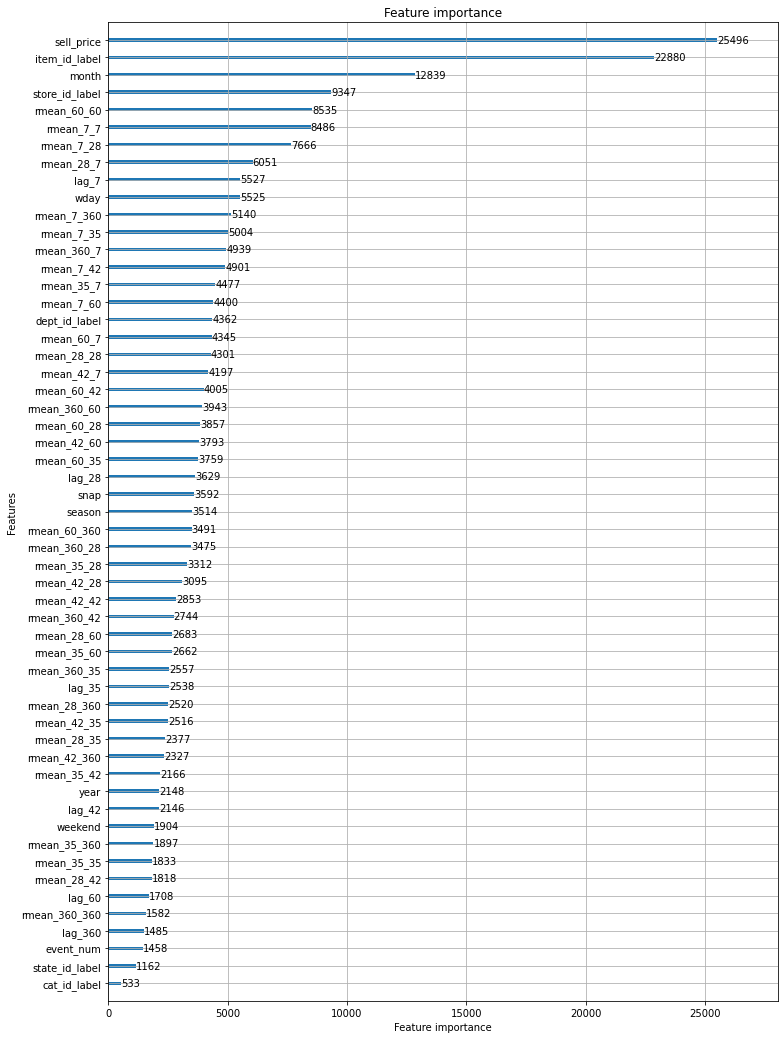

In [26]:
lgb.plot_importance(reg_model, figsize=(12, 18))

We see that _sell_price_ and _item_id_ seem overwhelmingly important. This makes sense, however could probably be optimised with different lag/rolling features. In hindsight calculating rolling standard deviation would probably be a good idea, perhaps splitting up sales price somehow based on lags? My understanding of this isn't quite ideal yet, something to think about for the future.

In [28]:
params_optimal = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'num_iterations': 500,
    'metric': 'rmse',
    'num_leaves': 500,
    'max_depth': 50,
    'learning_rate': 0.03,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.5,
    }
lgb_reg = lgb.LGBMRegressor(**params_optimal)

In [13]:
X_train.dtypes

rmean_60_28       float16
rmean_28_60       float16
rmean_35_7        float16
rmean_360_42      float16
rmean_42_42       float16
rmean_35_35       float16
rmean_42_60       float16
lag_35            float16
rmean_360_28      float16
year                int16
rmean_7_28        float16
store_id_label       int8
season               int8
rmean_28_42       float16
rmean_60_7        float16
lag_7             float16
item_id_label       int16
wday                 int8
snap                 int8
sell_price        float16
rmean_60_35       float16
rmean_60_60       float16
rmean_360_360     float16
rmean_60_360      float16
state_id_label       int8
rmean_28_35       float16
lag_28            float16
rmean_7_7         float16
rmean_35_60       float16
rmean_35_28       float16
rmean_42_28       float16
rmean_360_60      float16
rmean_7_42        float16
month                int8
lag_60            float16
rmean_28_360      float16
rmean_42_360      float16
rmean_360_35      float16
lag_360     

### Note
According to the competition guidelines, evaluating the predictions happens by using 50% of the training set. Since we went with 2014+ dates we kind of already accounted for that.

In [45]:
X_final = pd.concat([X_train, X_test])
X_final

,weekend,lag_60,rmean_360_28,rmean_28_7,rmean_42_28,rmean_35_28,item_id_label,rmean_35_42,dept_id_label,rmean_7_28,...,cat_id_label,rmean_35_360,season,rmean_42_42,rmean_7_7,rmean_42_7,rmean_28_42,lag_360,state_id_label,event_num
date,,,,,,,,,,,,,,,,,,,,,
2014-03-20,0,0.0,0.000000,0.000000,0.000000,0.000000,1437,0.000000,3,0.000000,...,1,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.0,0,0
2014-03-20,0,0.0,0.000000,0.000000,0.000000,0.000000,1438,0.000000,3,0.000000,...,1,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.0,0,0
2014-03-20,0,0.0,0.000000,0.000000,0.000000,0.000000,1439,0.000000,3,0.000000,...,1,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.0,0,0
2014-03-20,0,0.0,0.000000,0.000000,0.000000,0.000000,1440,0.000000,3,0.000000,...,1,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.0,0,0
2014-03-20,0,0.0,0.000000,0.000000,0.000000,0.000000,1441,0.000000,3,0.000000,...,1,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-22,1,0.0,0.250000,0.285645,0.000000,0.142822,1432,0.142822,2,0.571289,...,0,0.588867,1,0.166626,0.714355,0.000000,0.142822,1.0,2,0
2016-05-22,1,0.0,0.000000,0.142822,0.214233,0.285645,1433,0.190430,2,0.250000,...,0,0.022217,1,0.142822,0.000000,0.571289,0.214233,0.0,2,0
2016-05-22,1,0.0,1.036133,0.571289,0.928711,0.928711,1434,1.023438,2,0.714355,...,0,0.636230,1,1.166992,1.142578,1.571289,0.880859,1.0,2,0


In [46]:
y_final = pd.concat([y_train, y_test])
y_final

,items_sold
date,
2014-03-20,1
2014-03-20,0
2014-03-20,0
2014-03-20,3
2014-03-20,0
...,...
2016-05-22,1
2016-05-22,0
2016-05-22,2


In [47]:
lgb_reg.fit(X_final, y_final)

/home/cezgru/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.7, learning_rate=0.03,
              max_depth=50, metric='rmse', num_iterations=500, num_leaves=500,
              objective='tweedie', tweedie_variance_power=1.1)

In [48]:
y_final = lgb_reg.predict(X_test)

In [49]:
rmse_final =sqrt(mean_squared_error(y_test, y_final))
rmse_final

1.894256691447113

## Closing thoughts and future work
At this point all that is left is to change the format into one that is a valid submission. As (un)fun as it may sound, for this educational purpose I think having a proper model to make predictions should suffice. Needless to say, depending on how you wish to implement this, simply having raw prediction data may actually be prefferable. Perhaps one day I will format this and upload a late submission, but honestly I first want to work on this a bit more. Like was mentioned previously, I feel like a lot of things regarding features could be improved. Also I think I simplified the impact of events a bit too much, the EDA was not extensive enough to see that. I still have a rather basic understanding of lags and rolling features, making any of the, no doubt numerous, optimizations and implementations  unattainable. Researching and testing different models may yield better results, understanding time series in more detail would also help.